## 数据导入

In [1]:
import pandas as pd
import numpy as np
def read_xlsx(address, symbol, year):
    data = pd.read_excel(address, dtype={symbol: str})
    data.columns = data.columns.str.strip()   # 删除空格
    data[symbol] = data[symbol].astype(str).str.extract(r'(\d+)')   # 删除标点和英文字符
    data[symbol] = data[symbol].astype(str).str.zfill(6)    # 规范股票代码格式
    data = data.rename(columns={symbol: '股票代码'})
    # 如果year非空
    if year:
        data = data.rename(columns={year: '年份'})
    print("形状：", data.shape)
    print("列名：", data.columns)
    print("包含公司数量：", len(data['股票代码'].unique()))
    return data

In [2]:
regress_address = r'E:\ggq的文件\比赛\24统计建模\regress\e实证数据_筛选1994家企业_29489条数据_哑变量_工具变量_劳动力.xlsx'
regress_df = read_xlsx(regress_address, '股票代码', '年份')

形状： (29489, 70)
列名： Index(['股票代码', '年份', 'A股简称', 'A股上市日期', '省份', '城市', '所属行业', '板块', 'GTFP',
       'AIDIC', 'AIDIC_累加后log', 'AIGPT', 'AI', 'East', 'West', 'Mid', 'LnCit1',
       'LnCit2', 'GreenInnov', 'grd', 'gcon', 'IIP', 'OIP', 'Size', 'Lev',
       'Cashflow', 'FIXED', 'Growth', 'Board', 'Dual', 'Top1', 'TobinQ',
       'FirmAge', 'Employee', 'REC', 'INV', 'Intangible', 'AssetGrowth',
       'NetProfitGrowth', 'ITR', 'CAP', 'Invest1', 'Indep', 'Balance1',
       'Seperate', 'BM', 'PB', 'Ofee', 'Mfee', 'ATO', 'SA', 'WW', 'FC', 'KZ',
       'HighTech_1', 'HighTech_2', 'HighTech_3', 'HighTech_4', 'HighTech_5',
       'Pollute_1', 'Pollute_2', 'Pollute_3', 'SOE', 'Loss', '市场分割指数均值切分',
       '市场一体化指数均值切分', '人均gdp均值切分', '人工智能政策受益', '常规低技能劳动力占比', '非常规高技能劳动力占比'],
      dtype='object')
包含公司数量： 1994


In [5]:
# symbol_list_df = regress_df['股票代码'].unique()
# # 转换为dataframe，列名为code
# symbol_list_df = pd.DataFrame(symbol_list_df, columns=['code'])
# symbol_list_df.to_excel(r'E:\ggq的文件\比赛\24统计建模\data\zCSMAR_symbollist.xlsx', index=False)

In [5]:
regress_df['AI'] = regress_df['AI'] / 100

描述性统计

In [6]:
# GTFP AI Size Lev Fixed Growth Board Dual Top1 TobinQ做描述性统计
regress_df[['GTFP', 'AI', 'Size', 'Lev', 'FIXED', 'Growth', 'Board', 'Dual', 'Top1', 'TobinQ']].describe()

,GTFP,AI,Size,Lev,FIXED,Growth,Board,Dual,Top1,TobinQ
count,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000,29489.000000
mean,0.929006,0.134821,22.282150,0.462848,0.235753,0.170044,2.150966,0.213809,34.661009,1.928400
std,0.210710,0.215406,1.378788,0.213451,0.169890,0.476925,0.198957,0.410000,15.049578,1.335333
min,0.000000,0.000000,19.318716,0.055177,0.001582,-0.608093,1.609438,0.000000,8.526400,0.000000
25%,0.856460,0.000000,21.321226,0.300058,0.103382,-0.032417,2.079442,0.000000,22.832700,1.172782
50%,0.960717,0.000000,22.125748,0.461689,0.201460,0.090098,2.197225,0.000000,32.337600,1.529939
75%,1.059999,0.200000,23.098951,0.619712,0.336940,0.253179,2.197225,0.000000,45.064000,2.197569
max,1.166402,0.750000,26.328796,0.985628,0.726727,3.235005,2.708050,1.000000,74.823700,8.725405


进行机器学习的变量包括：企业基本财务信息、数字化转型、社会责任、绿色创新

In [7]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong'] 
mpl.rcParams['font.size'] = 12

In [8]:
# 数字化转型
address = r'E:\ggq的文件\比赛\24统计建模\data\zCSMAR数字化转型\z2011-2022数字化转型指数表.xlsx'
dig_df = read_xlsx(address, '股票代码', '年份')
# 社会责任
address = r'E:\ggq的文件\比赛\24统计建模\data\zCSMAR社会责任\CSRR_BasicInfo.xlsx'
soc_df = read_xlsx(address, '股票代码', None)
soc_df['统计截止日期'] = pd.to_datetime(soc_df['统计截止日期'])
soc_df['年份'] = soc_df['统计截止日期'].dt.year
soc_df = soc_df.drop(['统计截止日期'], axis=1)

形状： (41162, 9)
列名： Index(['年份', '股票代码', '战略引领评分', '技术驱动评分', '组织赋能评分', '环境支撑评分', '数字化成果评分',
       '数字化应用评分', '数字化转型指数'],
      dtype='object')
包含公司数量： 5255
形状： (30649, 18)
列名： Index(['股票代码', '统计截止日期', '纳税总额', '社会捐赠额', '是否经第三方机构审验', '是否参照GRI《可持续发展报告指南》',
       '是否披露股东权益保护', '是否披露债权人权益保护', '是否披露职工权益保护', '是否披露供应商权益保护',
       '是否披露客户及消费者权益保护', '是否披露环境和可持续发展', '是否披露公共关系和社会公益事业',
       '是否披露社会责任制度建设及改善措施', '是否披露安全生产内容', '是否披露公司存在的不足', '公告披露意愿',
       '审计师是否来自四大会计师事务所'],
      dtype='object')
包含公司数量： 1994


In [9]:
ml_df = regress_df.copy()
ml_df = pd.merge(ml_df, dig_df, on=['股票代码', '年份'], how='left')
ml_df = pd.merge(ml_df, soc_df, on=['股票代码', '年份'], how='left')
# 股票代码: object, A股简称: object, A股上市日期: object, 省份: object, 城市: object, 所属行业: object, 板块: object, 年份。转换为分类变量
ml_df = ml_df.drop(['股票代码', 'A股简称', 'A股上市日期', '城市'], axis=1)
ml_df = ml_df.drop(['LnCit1', 'LnCit2', 'GreenInnov', 'grd', 'gcon', 'IIP', 'OIP'], axis=1)
# 删除'AI'为0的
ml_df = ml_df[ml_df['AI'] != 0]
ml_df = ml_df.drop(['年份', 'ATO'], axis=1)
# categorical_features = ['省份', '所属行业', '板块', '年份']
categorical_features = ['省份', '所属行业', '板块']
for col in categorical_features:
    ml_df[col] = ml_df[col].astype('category')
for col in categorical_features:
    le = LabelEncoder()
    ml_df[col] = le.fit_transform(ml_df[col])

GTFP = ml_df.pop('GTFP')
X_train, X_test, y_train, y_test = train_test_split(ml_df, GTFP, test_size=0.2, random_state=0)

In [30]:
print(ml_df.shape)
print(ml_df.columns)

(12242, 79)
Index(['省份', '所属行业', '板块', 'AIDIC', 'AIDIC_累加后log', 'AIGPT', 'AI', 'East',
       'West', 'Mid', 'Size', 'Lev', 'Cashflow', 'FIXED', 'Growth', 'Board',
       'Dual', 'Top1', 'TobinQ', 'FirmAge', 'Employee', 'REC', 'INV',
       'Intangible', 'AssetGrowth', 'NetProfitGrowth', 'ITR', 'CAP', 'Invest1',
       'Indep', 'Balance1', 'Seperate', 'BM', 'PB', 'Ofee', 'Mfee', 'SA', 'WW',
       'FC', 'KZ', 'HighTech_1', 'HighTech_2', 'HighTech_3', 'HighTech_4',
       'HighTech_5', 'Pollute_1', 'Pollute_2', 'Pollute_3', 'SOE', 'Loss',
       '市场分割指数均值切分', '市场一体化指数均值切分', '人均gdp均值切分', '人工智能政策受益', '常规低技能劳动力占比',
       '非常规高技能劳动力占比', '战略引领评分', '技术驱动评分', '组织赋能评分', '环境支撑评分', '数字化成果评分',
       '数字化应用评分', '数字化转型指数', '纳税总额', '社会捐赠额', '是否经第三方机构审验',
       '是否参照GRI《可持续发展报告指南》', '是否披露股东权益保护', '是否披露债权人权益保护', '是否披露职工权益保护',
       '是否披露供应商权益保护', '是否披露客户及消费者权益保护', '是否披露环境和可持续发展', '是否披露公共关系和社会公益事业',
       '是否披露社会责任制度建设及改善措施', '是否披露安全生产内容', '是否披露公司存在的不足', '公告披露意愿',
       '审计师是否来自四大会计师事务所'],
      d

In [10]:
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'objective': 'regression',
    'importance_type': 'split',
    'random_state': 42
}
lgbm = lgb.LGBMRegressor(**params)
lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='mse', categorical_feature=categorical_features)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9949
[LightGBM] [Info] Number of data points in the train set: 9793, number of used features: 79
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 1.028892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=200,
              objective='regression', random_state=42)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


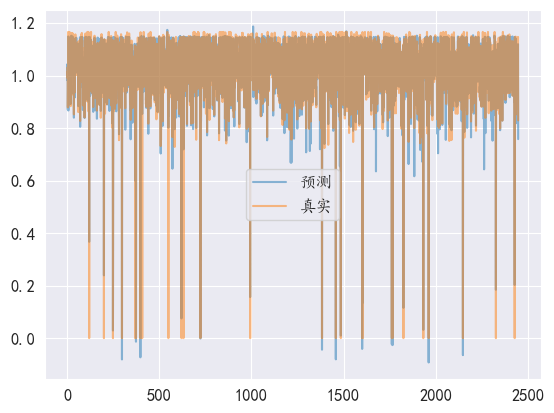

In [12]:
y_predict = lgbm.predict(X_test)
plt.plot(y_predict, label='预测', alpha=0.5)
plt.plot(y_test.to_numpy(), label='真实', alpha=0.5)
plt.legend()

In [13]:
# 计算预测与真实之间的均方误差
mse = mean_squared_error(y_test, y_predict)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0017


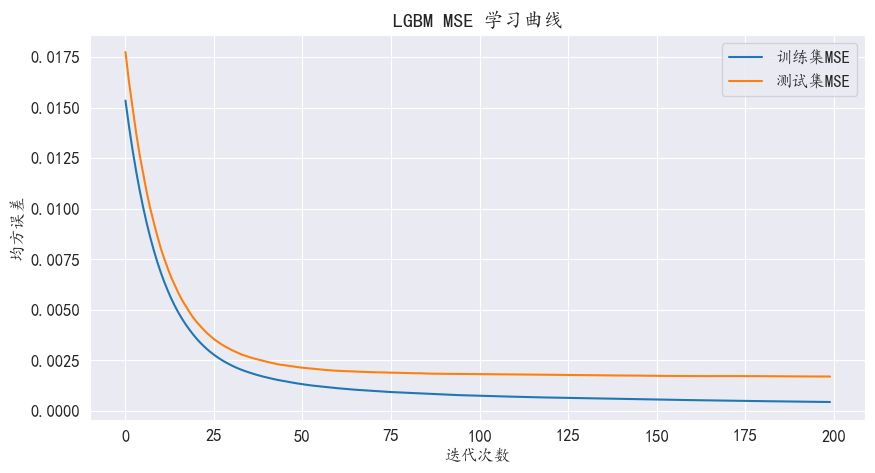

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


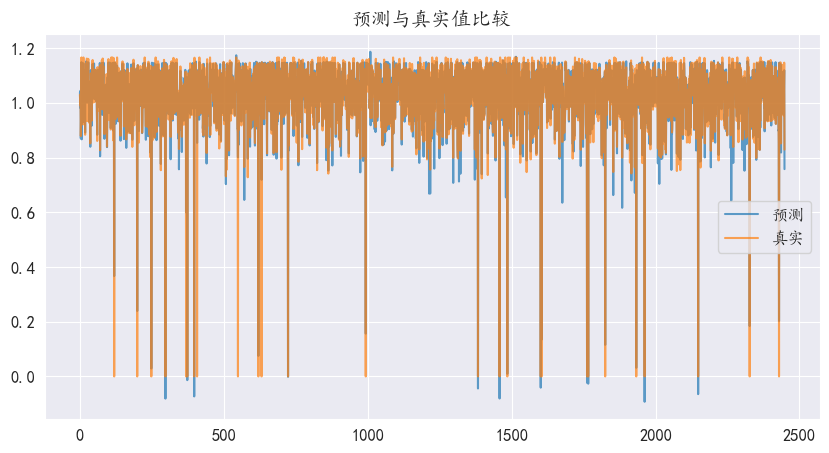

In [14]:
# 获取评估结果
evals_result = lgbm.evals_result_

# 绘制学习曲线
plt.figure(figsize=(10, 5))
plt.plot(evals_result['training']['l2'], label='训练集MSE')
plt.plot(evals_result['valid_1']['l2'], label='测试集MSE')
plt.title('LGBM MSE 学习曲线')
plt.xlabel('迭代次数')
plt.ylabel('均方误差')
plt.legend()
plt.show()

# 绘制预测结果和真实值的对比
y_predict = lgbm.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(y_predict, label='预测', alpha=0.7)
plt.plot(y_test.to_numpy(), label='真实', alpha=0.7)
plt.legend()
plt.title('预测与真实值比较')
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


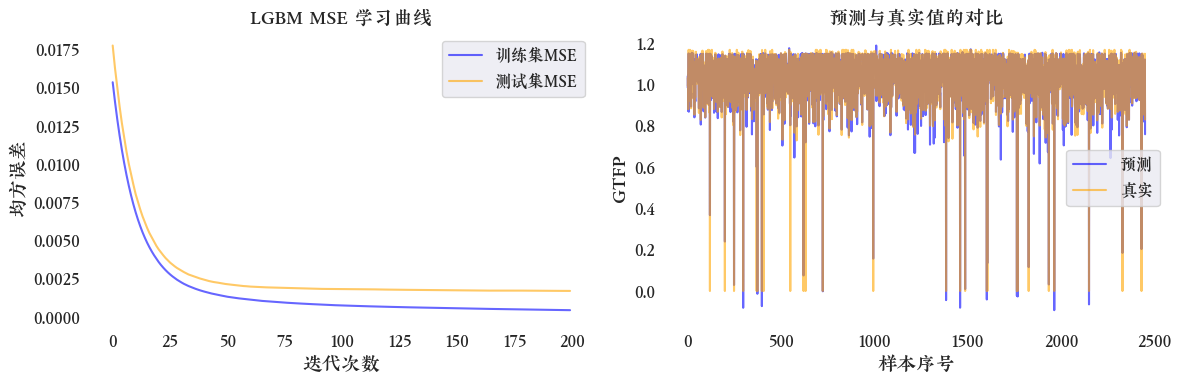

In [15]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 字体路径和字体属性设置
font_path = 'C:/Users/25105/AppData/Local/Microsoft/Windows/Fonts/FZCuJinLJW.TTF'
ax_font = FontProperties(fname=font_path, size=14)  # 轴标签字体
tick_font1 = FontProperties(fname=font_path, size=10)  # 刻度标签字体1
tick_font2 = FontProperties(fname=font_path, size=12)  # 刻度标签字体2

# 获取评估结果
evals_result = lgbm.evals_result_

# 创建大图和子图
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 第一个子图：绘制学习曲线
axes[0].plot(evals_result['training']['l2'], label='训练集MSE', color='blue', alpha=0.6)
axes[0].plot(evals_result['valid_1']['l2'], label='测试集MSE', color='orange', alpha=0.6)
axes[0].set_title('LGBM MSE 学习曲线', fontproperties=ax_font)
axes[0].set_xlabel('迭代次数', fontproperties=ax_font)
axes[0].set_ylabel('均方误差', fontproperties=ax_font)
axes[0].legend(prop=tick_font2)
for label in axes[0].get_xticklabels():
    label.set_fontproperties(tick_font2)
for label in axes[0].get_yticklabels():
    label.set_fontproperties(tick_font2)

# 第二个子图：绘制预测结果和真实值的对比
y_predict = lgbm.predict(X_test)
axes[1].plot(y_predict, label='预测', color='blue', alpha=0.6)
axes[1].plot(y_test.to_numpy(), label='真实', color='orange', alpha=0.6)
axes[1].set_title('预测与真实值的对比', fontproperties=ax_font)
axes[1].set_xlabel('样本序号', fontproperties=ax_font)
axes[1].set_ylabel('GTFP', fontproperties=ax_font)
axes[1].legend(prop=tick_font2)
for label in axes[1].get_xticklabels():
    label.set_fontproperties(tick_font2)
for label in axes[1].get_yticklabels():
    label.set_fontproperties(tick_font2)

for ax in axes:
    ax.set_facecolor('white')
    ax.grid(False)     

plt.tight_layout()
plt.savefig('E:/ggq的文件/比赛/24统计建模/paper/fig/lgbm_mseloss.png', dpi=300)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


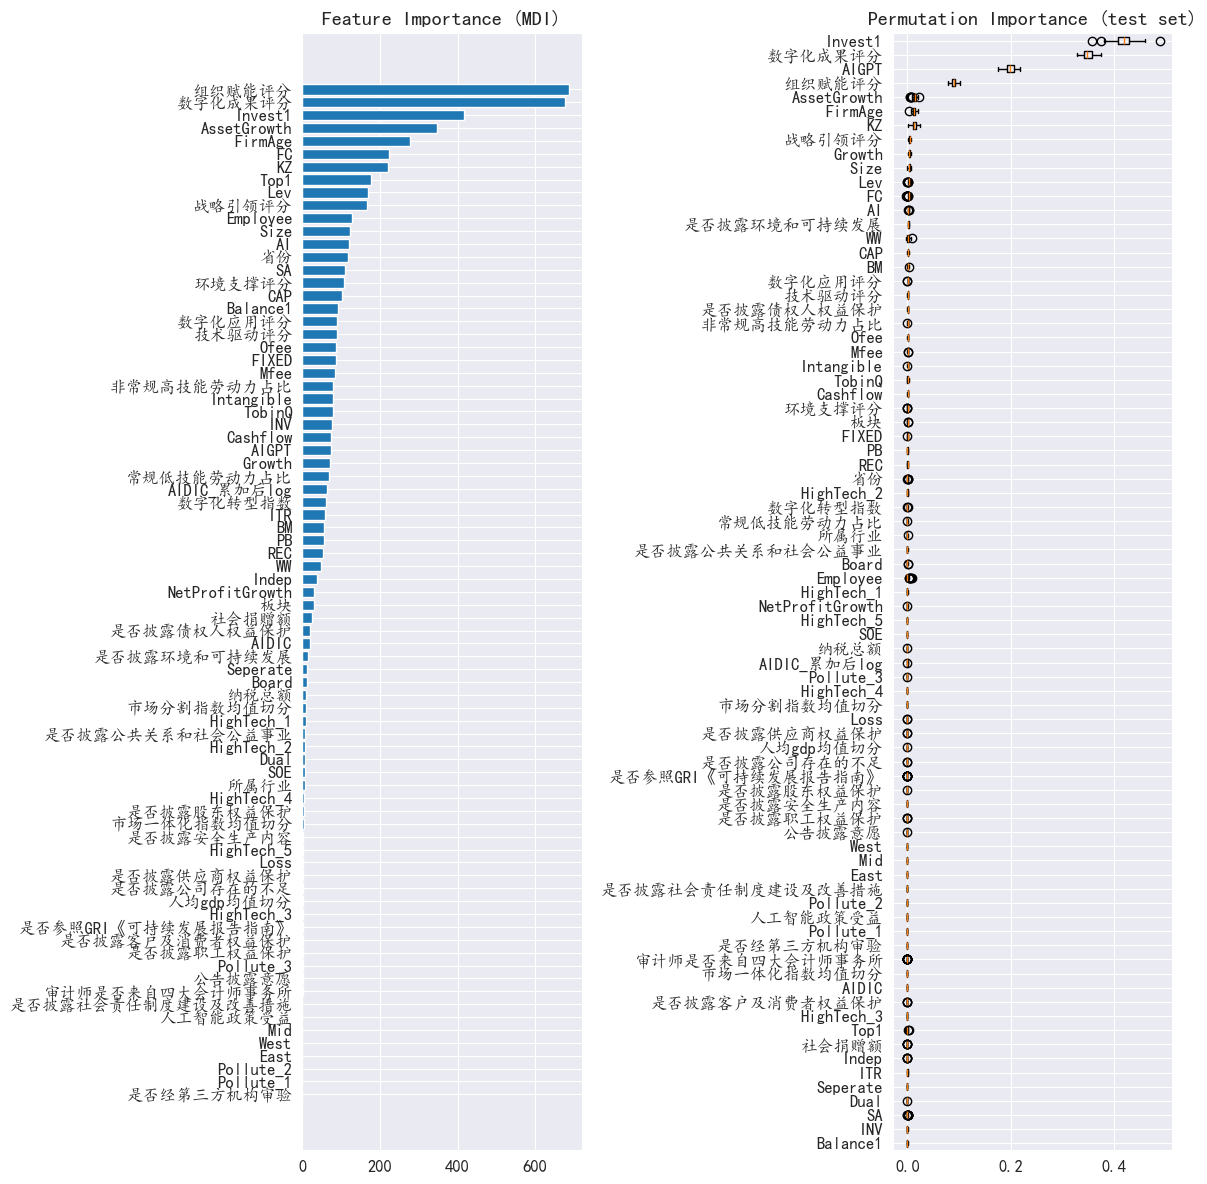

In [16]:
feature_importance = lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.title('Feature Importance (MDI)')

# 计算排列重要性
result = permutation_importance(lgbm, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx])  
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


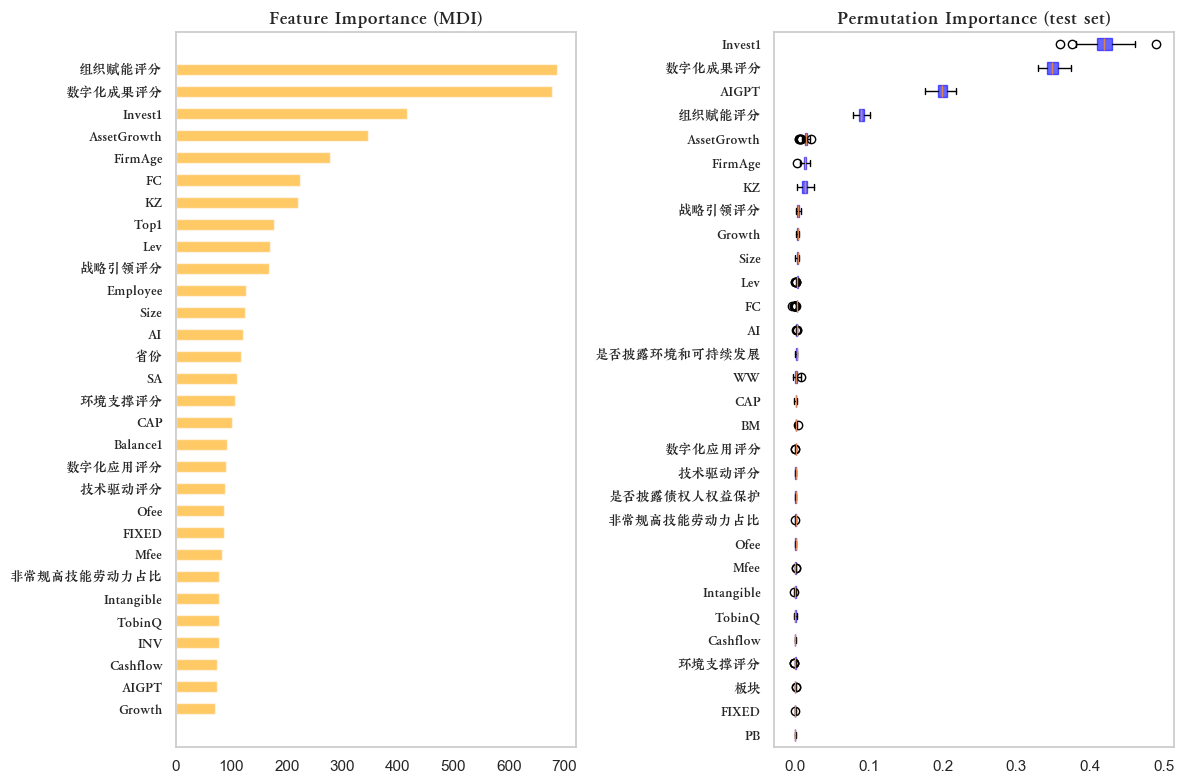

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# 字体路径和字体属性设置
font_path = 'C:/Users/25105/AppData/Local/Microsoft/Windows/Fonts/FZCuJinLJW.TTF'
ax_font = FontProperties(fname=font_path, size=14)  # 轴标签字体
tick_font = FontProperties(fname=font_path, size=10)  # 刻度标签字体

# 特征重要性计算和排序，只保留前30个
feature_importance = lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# 第一个子图：基于MDI的特征重要性
# 设置柱形宽度
axes[0].barh(pos, feature_importance[sorted_idx], align='center', color='orange', alpha=0.6, height=0.5)
axes[0].set_yticks(pos)
axes[0].set_yticklabels(X_train.columns[sorted_idx], fontproperties=tick_font)
axes[0].set_title('Feature Importance (MDI)', fontproperties=ax_font)
axes[0].set_facecolor('white')
axes[0].grid(False)

# 计算排列重要性，并排序显示前30个
result = permutation_importance(lgbm, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-30:]
axes[1].boxplot(result.importances[sorted_idx].T,
            vert=False, positions=pos, patch_artist=True,
            boxprops=dict(facecolor='blue', color='blue', alpha=0.6))
axes[1].set_yticks(pos)
axes[1].set_yticklabels(X_test.columns[sorted_idx], fontproperties=tick_font)
axes[1].set_title("Permutation Importance (test set)", fontproperties=ax_font)
axes[1].set_facecolor('white')
axes[1].grid(False)

fig.tight_layout()
plt.savefig('E:/ggq的文件/比赛/24统计建模/paper/fig/lgbm_imp.png', dpi=300)
plt.show()

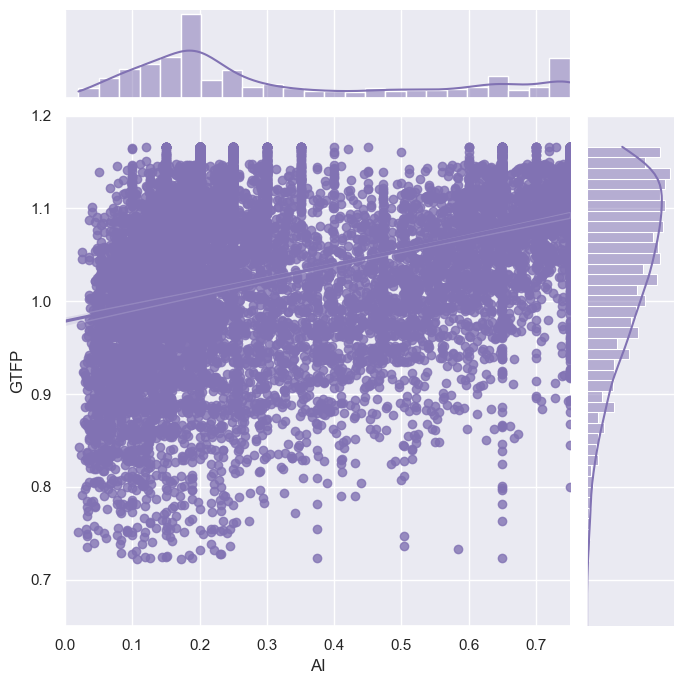

In [22]:
import seaborn as sns
sns.set_theme(style="darkgrid")
plot_df = regress_df[regress_df['AI'] != 0]
g = sns.jointplot(x="AI", y="GTFP", data=plot_df,
                  kind="reg", truncate=False,
                  xlim=(0, 0.75), ylim=(0.65, 1.2),
                  color="m", height=7)

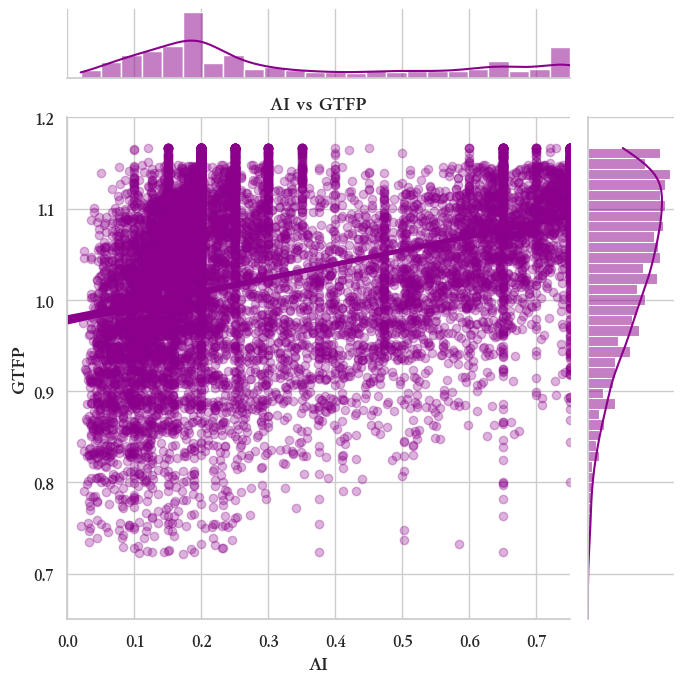

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 字体路径和字体属性设置
font_path = 'C:/Users/25105/AppData/Local/Microsoft/Windows/Fonts/FZCuJinLJW.TTF'
ax_font = FontProperties(fname=font_path, size=14)  # 轴标签字体
tick_font = FontProperties(fname=font_path, size=12)  # 刻度标签字体

# 设置主题和调色板
sns.set_theme(style="whitegrid")  # 设置白色网格背景
plot_df = regress_df[regress_df['AI'] != 0]

# 创建散点和回归线图
g = sns.jointplot(x="AI", y="GTFP", data=plot_df,
                  kind="reg", truncate=False,
                  xlim=(0, 0.75), ylim=(0.65, 1.2),
                  color="darkmagenta", height=7)

g.ax_joint.set_title('AI vs GTFP', fontproperties=ax_font)
g.ax_joint.set_xlabel('AI', fontproperties=ax_font)
g.ax_joint.set_ylabel('GTFP', fontproperties=ax_font)

# 设置刻度字体大小
for label in g.ax_joint.get_xticklabels():
    label.set_fontproperties(tick_font)
for label in g.ax_joint.get_yticklabels():
    label.set_fontproperties(tick_font)

# 更新图表元素的颜色和透明度
g.ax_joint.collections[0].set_alpha(0.3)  # 设置散点透明度
g.ax_joint.collections[1].set_alpha(1)  # 设置回归线透明度
g.ax_joint.collections[1].set_color('darkmagenta')  # 更新回归线颜色以确保一致性
plt.tight_layout()
plt.savefig('E:/ggq的文件/比赛/24统计建模/paper/fig/ai_gtfp.png', dpi=300)
plt.show()

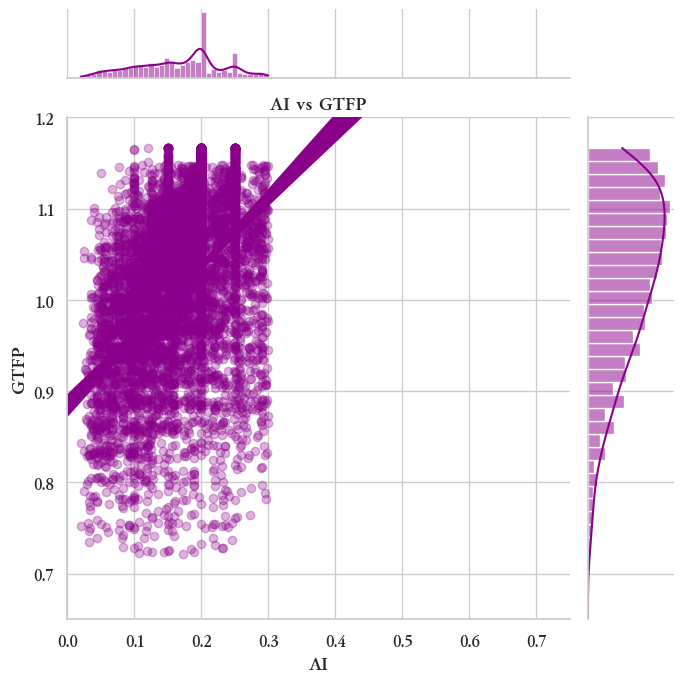

In [24]:
# 设置主题和调色板
sns.set_theme(style="whitegrid")  # 设置白色网格背景
plot_df = regress_df[regress_df['AI'] != 0]
# conditional distribution
plot_range = plot_df[(plot_df['AI'] < 0.30) & (plot_df['AI'] > 0)]
# 创建散点和回归线图
g = sns.jointplot(x="AI", y="GTFP", data=plot_range,
                  kind="reg", truncate=False,
                  xlim=(0, 0.75), ylim=(0.65, 1.2),
                  color="darkmagenta", height=7)

g.ax_joint.set_title('AI vs GTFP', fontproperties=ax_font)
g.ax_joint.set_xlabel('AI', fontproperties=ax_font)
g.ax_joint.set_ylabel('GTFP', fontproperties=ax_font)

# 设置刻度字体大小
for label in g.ax_joint.get_xticklabels():
    label.set_fontproperties(tick_font)
for label in g.ax_joint.get_yticklabels():
    label.set_fontproperties(tick_font)

# 更新图表元素的颜色和透明度
g.ax_joint.collections[0].set_alpha(0.3)  # 设置散点透明度
g.ax_joint.collections[1].set_alpha(1)  # 设置回归线透明度
g.ax_joint.collections[1].set_color('darkmagenta')  # 更新回归线颜色以确保一致性
plt.tight_layout()
plt.savefig('E:/ggq的文件/比赛/24统计建模/paper/fig/ai_gtfp_conditional.png', dpi=300)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

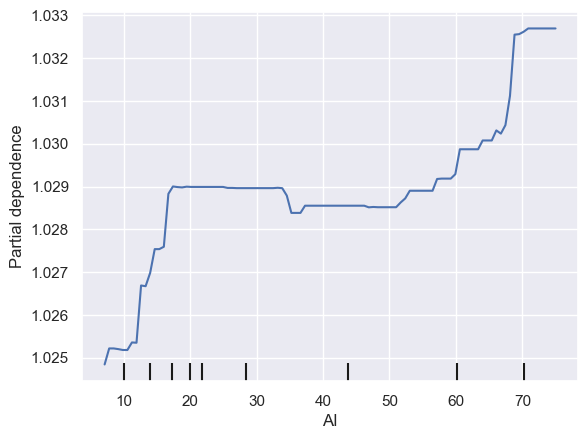

In [46]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(lgbm, X_train, ['AI'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

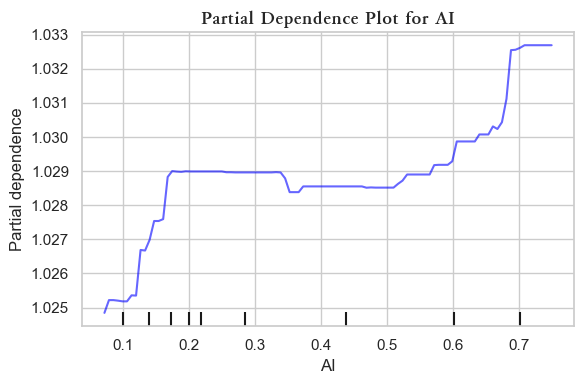

In [29]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.font_manager import FontProperties

# 字体路径和属性设置
font_path = 'C:/Users/25105/AppData/Local/Microsoft/Windows/Fonts/FZCuJinLJW.TTF'
ax_font = FontProperties(fname=font_path, size=14)  # 轴标签字体
tick_font = FontProperties(fname=font_path, size=12)  # 刻度标签字体

# 创建图表，设置尺寸为6x4英寸
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('white')  # 设置背景颜色为白色
ax.grid(False)  # 关闭网格线

# 设置字体属性
ax.set_title('Partial Dependence Plot for AI', fontproperties=ax_font)
ax.set_xlabel('AI', fontproperties=ax_font)
ax.set_ylabel('Partial Dependence', fontproperties=ax_font)

# 应用字体属性到刻度标签
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(tick_font)
    
# 生成偏依赖图对象
display = PartialDependenceDisplay.from_estimator(
    lgbm, X_train, ['AI'],
    ax=ax,
    line_kw={"color": "blue", "alpha": 0.6}  # 设置线条颜色和透明度
)

# # 使用plot方法绘制，不再传递ax，使用绑定的ax
# display.plot(pd_line_kw={"color": "blue", "alpha": 0.6})
plt.tight_layout()
plt.savefig('E:/ggq的文件/比赛/24统计建模/paper/fig/pdp_ai.png', dpi=300)
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

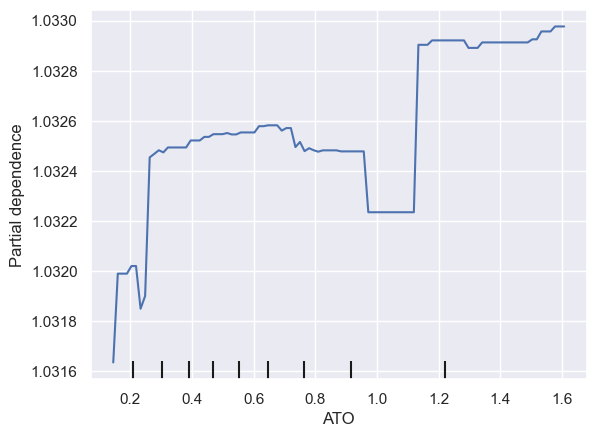

In [25]:
PartialDependenceDisplay.from_estimator(lgbm, X_train, ['ATO'])

In [26]:
def draw_marginal_plot(data, feat_axis, num_parts):
    max_v = np.max(data[:, feat_axis])
    min_v = np.min(data[:, feat_axis])
    step = (max_v - min_v) / num_parts
    df = pd.DataFrame(data)
    data_record = []
    for each_part in range(num_parts):
        low_bound = min_v + each_part * step
        upper_bound = min_v + (each_part + 1) * step
        data_select = df[(df[feat_axis] > low_bound) & (df[feat_axis] < upper_bound)]
        if len(data_select) > 0:
            data_pred = GBDTreg.predict(data_select)
            data_mean = np.array(data_pred).mean()
            data_std = np.std(np.array(data_pred))
            data_record.append((each_part, data_mean, data_std))
    return data_record, step

In [52]:
feat_id = ml_df.columns.get_loc('AI')
data_record, step = draw_marginal_plot(X_train, feat_id, 50)
data_record = np.array(data_record)
plt.plot(data_record[:, 0] * step, data_record[:, 1])
plt.xlabel("feat {}".format(feat_id))
plt.ylabel("avg predict")
plt.title("Marginal Plot")

InvalidIndexError: (slice(None, None, None), 7)